In [1]:
# %%
import cv2
import gtsam
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
from scipy.spatial.transform import Rotation as R
import gtsam.utils.plot as gtsam_plot
import rospy
from geometry_msgs.msg import PoseStamped
from nav_msgs.msg import Path


plt.rcParams['figure.figsize'] = [20, 10]
rospy.init_node('pathfinder', anonymous=True)


In [2]:

kScaleKitti = 1  

class GroundTruth(object):
   def __init__(self, path, associations=None):
       self.path=path 
       self.associations=associations 
       self.filename=None
       self.file_associations=None         
       self.data=None 
       self.scale = 1

   def getDataLine(self, frame_id):
       return self.data[frame_id].strip().split()
   
   def getPoseAndAbsoluteScale(self, frame_id):
       return 0,0,0,1

   # convert the dataset into 'Simple' format  [x,y,z,scale]
   def convertToSimpleXYZ(self, filename='groundtruth.txt'):
       out_file = open(filename,"w")
       num_lines = len(self.data)
       print('num_lines:', num_lines)
       for ii in range(num_lines):
           x,y,z,scale = self.getPoseAndAbsoluteScale(ii)
           if ii == 0:
               scale = 1 # first sample: we do not have a relative 
           out_file.write( "%f %f %f %f \n" % (x,y,z,scale) )
       out_file.close()

class KittiGroundTruth(GroundTruth):
   def __init__(self, filename, associations=None): 
       super().__init__(filename, associations)
       self.scale = kScaleKitti
       self.filename= filename   # N.B.: this may depend on how you deployed the groundtruth files 
       with open(self.filename) as f:
           self.data = f.readlines()
           self.found = True 
       if self.data is None:
           sys.exit('ERROR while reading groundtruth file: please, check how you deployed the files and if the code is consistent with this!') 

   def getPoseAndAbsoluteScale(self, frame_id1, frame_id2):
       assert frame_id1 < frame_id2
       ss = self.getDataLine(frame_id1)
       x_prev = self.scale*float(ss[3])
       y_prev = self.scale*float(ss[7])
       z_prev = self.scale*float(ss[11])     
       ss = self.getDataLine(frame_id2) 
       x = self.scale*float(ss[3])
       y = self.scale*float(ss[7])
       z = self.scale*float(ss[11])
       abs_scale = np.sqrt((x - x_prev)*(x - x_prev) + (y - y_prev)*(y - y_prev) + (z - z_prev)*(z - z_prev))
       return x,y,z,abs_scale 




In [3]:
_S = []
class Frame():
    def __init__(self, id, kps, descs):
        self.id = id
        self.kps = kps
        self.descs = descs

class Transform():
    def __init__(self, frame1, frame2, R, t):
        assert frame1.id < frame2.id

        self.frame1 = frame1
        self.frame2 = frame2
        self.R = R
        self.t = t
    
    def __add__(self, transform2):
        assert isinstance(transform2, Transform)
        t = self.t + (self.R @ transform2.t)
        R = transform2.R @ self.R
        return Transform(self.frame1, transform2.frame2, R, t)
    
class Processor():
    def __init__(self, path):
        self.frames = glob.glob(path)
        self.frames.sort()
        self.pp = (601.8873, 183.1104)
        self.focal = 707.0912
        self.detector = cv2.AKAZE_create()
        self.truth = KittiGroundTruth("/images/poses.txt")

        self.pointer = 1
        self.m_rotation = None
        self.m_translation = None
        self.transform = None

        frame = self.detectAndComputeFrame(0)
        self.prev_kps = frame.kps
        self.prev_descs = frame.descs
        self.bf = cv2.BFMatcher(cv2.NORM_HAMMING) # TODO replace?

        self.track = []
        self.processed_frames = []
        self.transforms = {}
        
    
    def detectAndComputeFrame(self, i):
        frame = cv2.imread(self.frames[i], cv2.IMREAD_GRAYSCALE)
        (next_kps, next_descs) = self.detector.detectAndCompute(frame, None)
        frame = Frame(i, next_kps, next_descs)
        return frame

    def estimate_transform(self, frame1, frame2, debug=False):
        matches = self.bf.knnMatch(frame1.descs, frame2.descs, k=2)
        if len(matches) < 500:
            return None

        matches_prev = []
        matches_next = []
        
        if debug:
            debug_frames = [cv2.imread(self.frames[frame1.id]), cv2.imread(self.frames[frame2.id])]
        for m,n in matches:
            if m.distance < 0.8*n.distance:
                matches_prev.append(frame1.kps[m.queryIdx].pt)
                matches_next.append(frame2.kps[m.trainIdx].pt)

                if debug:
                    pa = (int(matches_prev[-1][0]),int(matches_prev[-1][1]))
                    pb = (int(matches_next[-1][0]),int(matches_next[-1][1]))
                    debug_frames[0] = cv2.line(debug_frames[0], pa, pb, (0,255,0), 1) 
                    debug_frames[1] = cv2.line(debug_frames[1], pa, pb, (0,255,0), 1) 

        matches_prev = np.array(matches_prev)
        matches_next = np.array(matches_next)

        E, mask = cv2.findEssentialMat(matches_prev, matches_next, focal=self.focal, pp=self.pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        points, R_est, t_est, mask_pose = cv2.recoverPose(E, matches_prev, matches_next, focal=self.focal, pp=self.pp)
        
        x,y,z,scale = self.truth.getPoseAndAbsoluteScale(frame1.id, frame2.id)
        t_est *= scale

        transform = Transform(frame1, frame2, R_est, t_est)

        if debug:
            return transform, debug_frames
        return transform

    # def process_next(self):
    #     if self.pointer >= len(self.frames):
    #         return None
        
    #     frame = self.detectAndComputeFrame(self.pointer)
    #     (next_kps, next_descs) = frame.kps, frame.descs
    #     truth_x, truth_y, truth_z, scale = self.truth.getPoseAndAbsoluteScale(self.pointer-1, self.pointer)
    #     self.pointer += 1

    #     matches = self.bf.knnMatch(self.prev_descs,next_descs, k=2)
    #     _S.append(scale)
    #     matches_prev = []
    #     matches_next = []
    #     for m,n in matches:
    #         if m.distance < 0.8*n.distance:
    #             matches_prev.append(self.prev_kps[m.queryIdx].pt)
    #             matches_next.append(next_kps[m.trainIdx].pt)
                
    #             pa = (int(matches_prev[-1][0]),int(matches_prev[-1][1]))
    #             pb = (int(matches_next[-1][0]),int(matches_next[-1][1]))
    #             self.last_frame = cv2.line(self.last_frame, pa, pb, (0,255,0), 1) 
    #     matches_prev = np.array(matches_prev)
    #     matches_next = np.array(matches_next)

    #     self.prev_kps = next_kps
    #     self.prev_descs = next_descs

    #     E, mask = cv2.findEssentialMat(matches_prev, matches_next, focal=self.focal, pp=self.pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    #     points, R_est, t_est, mask_pose = cv2.recoverPose(E, matches_prev, matches_next, focal=self.focal, pp=self.pp)
    #     # print(np.sqrt(np.sum(t_est.T[0]**2)), self.frames[self.pointer])
    #     # transform = np.vstack((np.hstack((R_est, t_est)), (0, 0, 0, 1)))

        

    #     if self.m_rotation is None:
    #         self.m_rotation = R_est
    #         self.m_translation = t_est
    #         # self.transform = transform
    #     else:
    #         # self.transform = transform @ self.transform
    #         self.m_translation = self.m_translation + (self.m_rotation @ t_est) * scale
    #         self.m_rotation = R_est @ self.m_rotation

    #     self.track.append([self.m_translation.T[0], np.array([truth_x, truth_y, truth_z])])

        # return transform


p = Processor("/images/*.png")
p.estimate_transform(p.detectAndComputeFrame(0), p.detectAndComputeFrame(3))
# plt.imshow(p.last_frame)




In [4]:
p = Processor("/images/*.png")

frames = []
for i in tqdm(range(400)):
    frames.append(p.detectAndComputeFrame(i))


100%|██████████| 400/400 [00:24<00:00, 16.29it/s]


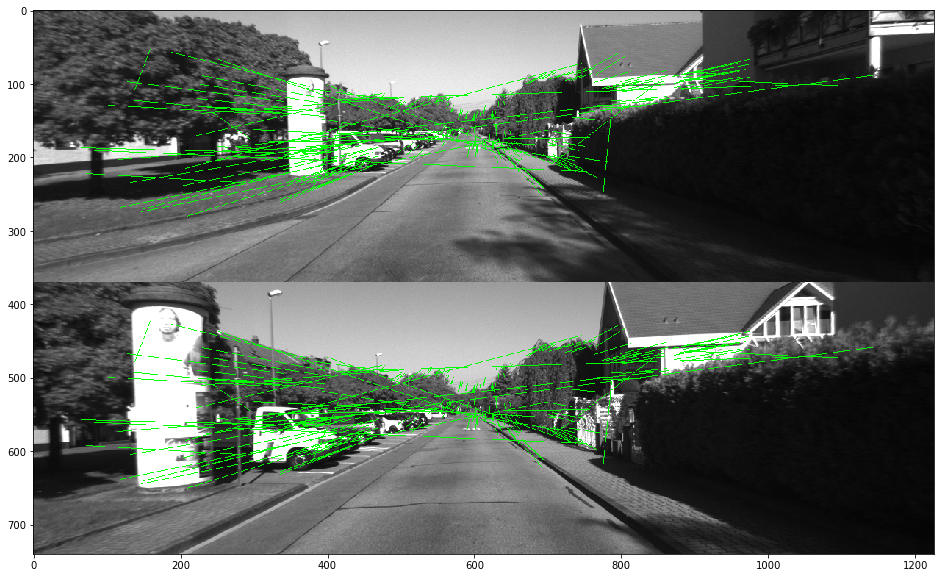

In [5]:
_, (im1, im2) = p.estimate_transform(frames[20], frames[30], True)
plt.imshow(np.vstack((im1, im2)))

In [6]:
global_transform = None
track = []

PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3]*6))
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3]*6))

graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()
graph.add(gtsam.PriorFactorPose3(0, gtsam.Pose3(), PRIOR_NOISE))
initial_estimate.insert(0, gtsam.Pose3())



for i in tqdm(range(1, len(frames))):
    transform = p.estimate_transform(frames[i-1], frames[i])
    if global_transform is None:
        global_transform = transform 
    else :
        global_transform = global_transform + transform 

    x,y,z,_ = p.truth.getPoseAndAbsoluteScale(transform.frame1.id, transform.frame2.id)
    track.append([global_transform.t.T[0], [x, y, z]])

    x,y,z = global_transform.t.T[0]
    rot = gtsam.Rot3(global_transform.R)
    initial_estimate.insert(i, gtsam.Pose3(rot, gtsam.Point3(x,y,z)))

    x,y,z = transform.t.T[0]
    rot = gtsam.Rot3(transform.R)
    graph.add(gtsam.BetweenFactorPose3(i-1, i, gtsam.Pose3(rot, gtsam.Point3(x,y,z)), ODOMETRY_NOISE))

    for j in np.random.choice(range(1,5), 4):
        i_ahead = i+j
        if len(frames) <= i_ahead:
            break
        transform = p.estimate_transform(frames[i-1], frames[i_ahead])
        if not transform:
            continue

        x,y,z = transform.t.T[0]
        rot = gtsam.Rot3(transform.R)
        graph.add(gtsam.BetweenFactorPose3(i-1, i_ahead, gtsam.Pose3(rot, gtsam.Point3(x,y,z)), ODOMETRY_NOISE))

track = np.array(track)

100%|██████████| 399/399 [00:41<00:00,  9.63it/s]


In [7]:
parameters = gtsam.GaussNewtonParams()

# Stop iterating once the change in error between steps is less than this value
parameters.setRelativeErrorTol(1e-5)
# Do not perform more than N iteration steps
parameters.setMaxIterations(100)
# Create the optimizer ...
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)
# ... and optimize
result = optimizer.optimize()
# print("Final Result:\n{}".format(result))

# 5. Calculate and print marginal covariances for all variables
marginals = gtsam.Marginals(graph, result)
# for i in range(1, len(result.keys())):
#     print("X{} covariance:\n{}\n".format(i, marginals.marginalCovariance(i)))

# fig = plt.figure(0)
# for i in range(1, len(result.keys())):
#     gtsam_plot.plot_pose3(0, result.atPose3(i), 0.5, marginals.marginalCovariance(i))

# plt.axis('equal')
# plt.show()

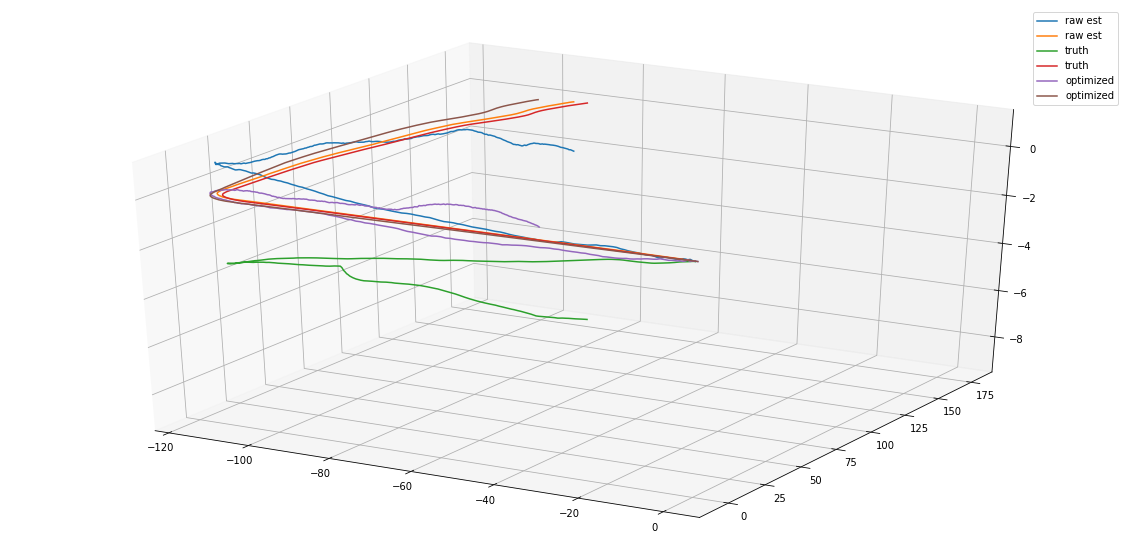

In [9]:
optimized = np.array([[result.atPose3(i).x(), result.atPose3(i).y(),result.atPose3(i).z()] for i in result.keys()])

plt.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')

def plot3(x, y, z, label):
    ax.plot(x, y, z, label=label)
    ax.plot(x, y, 0, label=label)

plot3(track[:,0,2], track[:,0,0], track[:,0,1], label="raw est")
plot3(-track[:,1,2], track[:,1,0], track[:,1,1], label="truth")
plot3(optimized[:,2], optimized[:,0], -optimized[:,1], label="optimized")
ax.legend()

plt.show()
# track

In [11]:
def viz_path(X, Y, Z, label):
    path_publisher = rospy.Publisher(label, Path, queue_size=1)

    path_msg = Path()
    path_msg.header.frame_id = 'map'
    for x, y, z in zip(X, Y, Z):
        pose_msg = PoseStamped()

        pose_msg.pose.position.x = x / 100
        pose_msg.pose.position.y = y / 100
        pose_msg.pose.position.z = z / 100
        pose_msg.pose.orientation.x = 0
        pose_msg.pose.orientation.y = 0
        pose_msg.pose.orientation.z = 0
        pose_msg.pose.orientation.w = 1
        path_msg.poses.append(pose_msg)

    path_publisher.publish(path_msg)
    
viz_path(track[:,0,2], track[:,0,0], track[:,0,1], label="raw_est")
viz_path(-track[:,1,2], track[:,1,0], track[:,1,1], label="truth")
viz_path(optimized[:,2], optimized[:,0], -optimized[:,1], label="optimized")

In [ ]:
import math
import gtsam.utils.plot as gtsam_plot

def vector3(x, y, z):
    """Create 3d double numpy array."""
    return np.array([x, y, z], dtype=np.float)

# Create noise models
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(vector3(0.3, 0.3, 0.1))
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(vector3(0.2, 0.2, 0.1))

# 1. Create a factor graph container and add factors to it
graph = gtsam.NonlinearFactorGraph()

# 2a. Add a prior on the first pose, setting it to the origin
# A prior factor consists of a mean and a noise ODOMETRY_NOISE (covariance matrix)
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), PRIOR_NOISE))

# 2b. Add odometry factors
# Create odometry (Between) factors between consecutive poses
graph.add(gtsam.BetweenFactorPose2(1, 2, gtsam.Pose2(2, 0, 0), ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPose2(
    2, 3, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPose2(
    3, 4, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))
graph.add(gtsam.BetweenFactorPose2(
    4, 5, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))

# 2c. Add the loop closure constraint
# This factor encodes the fact that we have returned to the same pose. In real
# systems, these constraints may be identified in many ways, such as appearance-based
# techniques with camera images. We will use another Between Factor to enforce this constraint:
graph.add(gtsam.BetweenFactorPose2(
    5, 2, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))
print("\nFactor Graph:\n{}".format(graph))  # print

# 3. Create the data structure to hold the initial_estimate estimate to the
# solution. For illustrative purposes, these have been deliberately set to incorrect values
initial_estimate = gtsam.Values()
initial_estimate.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
initial_estimate.insert(2, gtsam.Pose2(2.3, 0.1, -0.2))
initial_estimate.insert(3, gtsam.Pose2(4.1, 0.1, math.pi / 2))
initial_estimate.insert(4, gtsam.Pose2(4.0, 2.0, math.pi))
initial_estimate.insert(5, gtsam.Pose2(2.1, 2.1, -math.pi / 2))
print("\nInitial Estimate:\n{}".format(initial_estimate))  # print

# 4. Optimize the initial values using a Gauss-Newton nonlinear optimizer
# The optimizer accepts an optional set of configuration parameters,
# controlling things like convergence criteria, the type of linear
# system solver to use, and the amount of information displayed during
# optimization. We will set a few parameters as a demonstration.
parameters = gtsam.GaussNewtonParams()

# Stop iterating once the change in error between steps is less than this value
parameters.setRelativeErrorTol(1e-5)
# Do not perform more than N iteration steps
parameters.setMaxIterations(100)
# Create the optimizer ...
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)
# ... and optimize
result = optimizer.optimize()
print("Final Result:\n{}".format(result))

# 5. Calculate and print marginal covariances for all variables
marginals = gtsam.Marginals(graph, result)
for i in range(1, 6):
    print("X{} covariance:\n{}\n".format(i, marginals.marginalCovariance(i)))

fig = plt.figure(0)
for i in range(1, 6):
    gtsam_plot.plot_pose2(0, result.atPose2(i), 0.5, marginals.marginalCovariance(i))

plt.axis('equal')
plt.show()